### Experimento Final: Método base `ExplainSumm`  y Calidad de los Resúmenes Generados 

**Objetivo**: El objetivo principal de este experimento final tiene como propósito responder a **RQ3: ¿Es la propia calidad de los resumenes a comparar una causa directa de la perdida de capacidad predictiva de ciertos rasgos y/o metricas?**. Para ello como ya adelantamos anteriormente, este experimento se apalanca en el método `ExplainSumm`, explicado anteriormente. 

**Descripcón**:
Para entender si la propia calidad de los resumenes a comparar es una causa directa de la perdida de capacidad predictiva de ciertos rasgos y/o metricas, se procede a segmentar el dataset atendiendo al grado de preferencia sobre los resúmenes de referencia de los modelos. Es decir, como se aprecia en la imagen a continuación, cada modelo de resumen automático, según su tipología y número de parámetros tiene un grado de preferencia u otro, o lo que es lo mismo, genera resumenes de mayor o menor calidad, incluso llegando a ser indistingibles de los resúmenes generados por anotadores humanos (`Grado de Preferencia sobre la Referencia >= 50%`). 

<p align="center">
  <img src="figs/fraction_preferred_to_ref_vs_model_type.png" alt="Alternative text" />
</p>

Una vez identificado los niveles de calidad para cada uno de los diferentes modelos de resúmenes automáticos, somos capaces de segmentar el dataset teniendo en cuenta el origen de los resúmenes a comparar en cada observación. De esta forma aislaremos aquellas observaciones donde se compararen resúmenes generados por modelos que tengan como resultado resúmenes de calidad similares. Aquí se segmente el dataset en 3 grupos. Calidad de resúmenes alta, media y baja. 

In [68]:
import time
import shap
import optuna 

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from src.explainability import ExplainSumm
from src.utils import train_test_split_comparision
from src.data_visualization import (
    visualize_metrics, 
    visualize_shap_values, 
    visualize_shap_values_by_quality, 
    plot_shap_dependence,
)

from data.policy_data import policy_dict

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pd.set_option('display.max_columns', None)

##### 1. Load comparisons segmented by `fraction preferred to reference` 

In [3]:
# 1. Load segmented comparisons
df = pd.read_csv("data\segmentation\comparisons_segmentation.csv")
df.columns = df.columns.str.replace("xfmr", "sentence")

# 2. Non-features definition
comparison_columns = [
    "worker",
    "batch",
    "split",
    "id",
    "source",
    "subsource",
    "title",
    "text",
    "summary_0",
    "policy_0",
    "note_0",
    "summary_1",
    "policy_1",
    "note_1",
    "confidence",
    "ref_summary",
    "choice",
]

# 3. Target
target = ["choice"]

##### 2. Apply SummXAI to each subsample

In [4]:
# SummXAI - Low
summ_xai_low = ExplainSumm(
    df=df[df["Quality"] == "Low"].drop("Quality", axis=1),
    target=target, 
    non_features=comparison_columns,
    n_trials=50,
    n_boost_round=250,
)

# SummXAI - Mid
summ_xai_mid = ExplainSumm(
    df=df[df["Quality"] == "Medium"].drop("Quality", axis=1),
    target=target, 
    non_features=comparison_columns,
    n_trials=50,
    n_boost_round=250,
)

# SummXAI - High
summ_xai_high = ExplainSumm(
    df=df[df["Quality"] == "High"].drop("Quality", axis=1),
    target=target, 
    non_features=comparison_columns,
    n_trials=50,
    n_boost_round=250,
)

Reducing dataset memory...
Mem. usage decreased to  8.15 Mb (52.2% reduction)
Training model...
Generating predictions...
Calculate classification metrics...
Reducing dataset memory...
Mem. usage decreased to  5.22 Mb (52.2% reduction)
Training model...
Generating predictions...
Calculate classification metrics...
Reducing dataset memory...
Mem. usage decreased to  0.86 Mb (52.2% reduction)
Training model...
Generating predictions...
Calculate classification metrics...


In [37]:
summ_xai_mid = ExplainSumm(
    df=df[df["Quality"] == "Medium"].drop("Quality", axis=1),
    target=target, 
    non_features=comparison_columns,
    n_trials=50,
    n_boost_round=250,
)

Reducing dataset memory...
Mem. usage decreased to  5.22 Mb (52.2% reduction)
Training model...
Generating predictions...
Calculate classification metrics...


##### 3. Confusion matrix of each subsample

Low Quality:
Accuracy: 62.69 %
Precision: 62.09 %
Recall: 62.74 %
F1 Score: 62.41 %
ROC AUC: 62.69 %


Mid Quality:
Accuracy: 60.52 %
Precision: 61.74 %
Recall: 61.25 %
F1 Score: 61.49 %
ROC AUC: 60.5 %


High Quality:
Accuracy: 59.33 %
Precision: 63.42 %
Recall: 59.89 %
F1 Score: 61.6 %
ROC AUC: 59.28 %




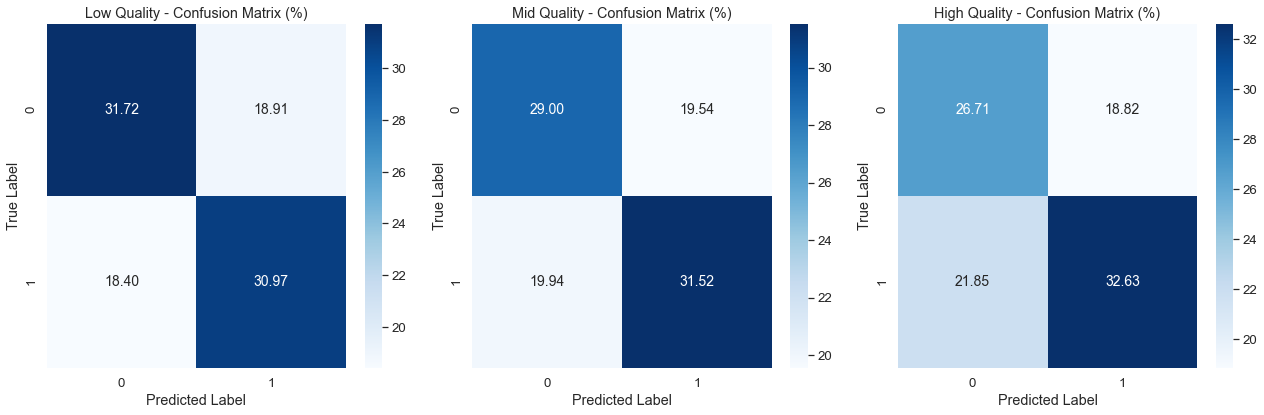

In [33]:
visualize_metrics(
    [summ_xai_low.metrics, summ_xai_mid.metrics, summ_xai_high.metrics],
    titles=["Low Quality", "Mid Quality", "High Quality"],
    filename="figs/confusion_matrices",
)

##### 4. Visualize SHAP values by `fraction preferred to reference` 

##### 4.1. Low Quality Summaries

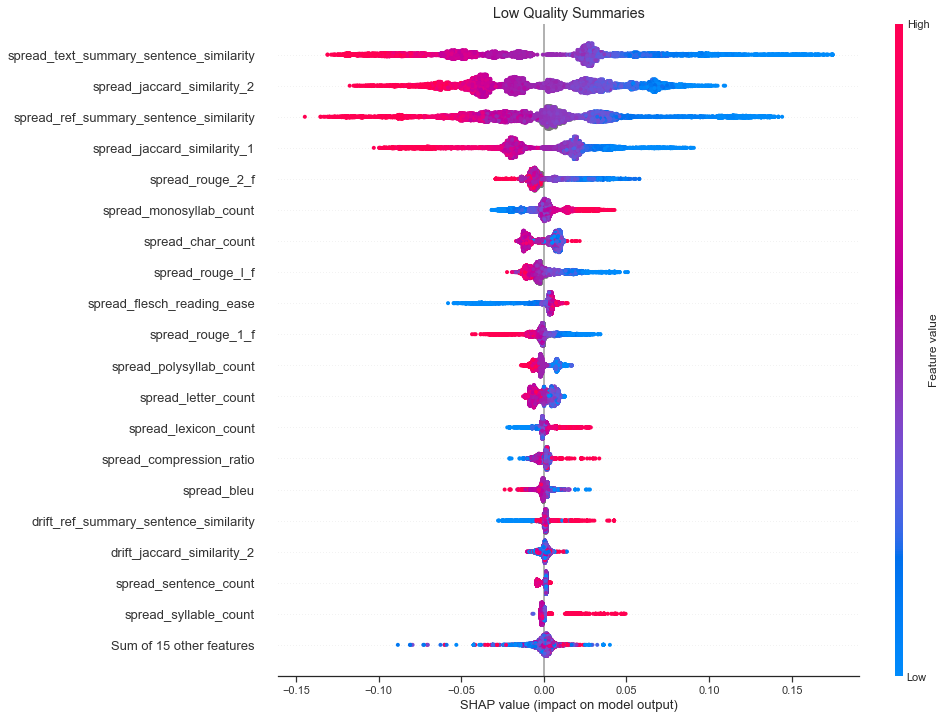

In [52]:
visualize_shap_values(
    [summ_xai_low.shap_values], 
    [summ_xai_low.X_test],
    ["Low Quality Summaries"], 
    filename="figs/shap_values_low",
)

##### 4.2. Mid Quality Summaries

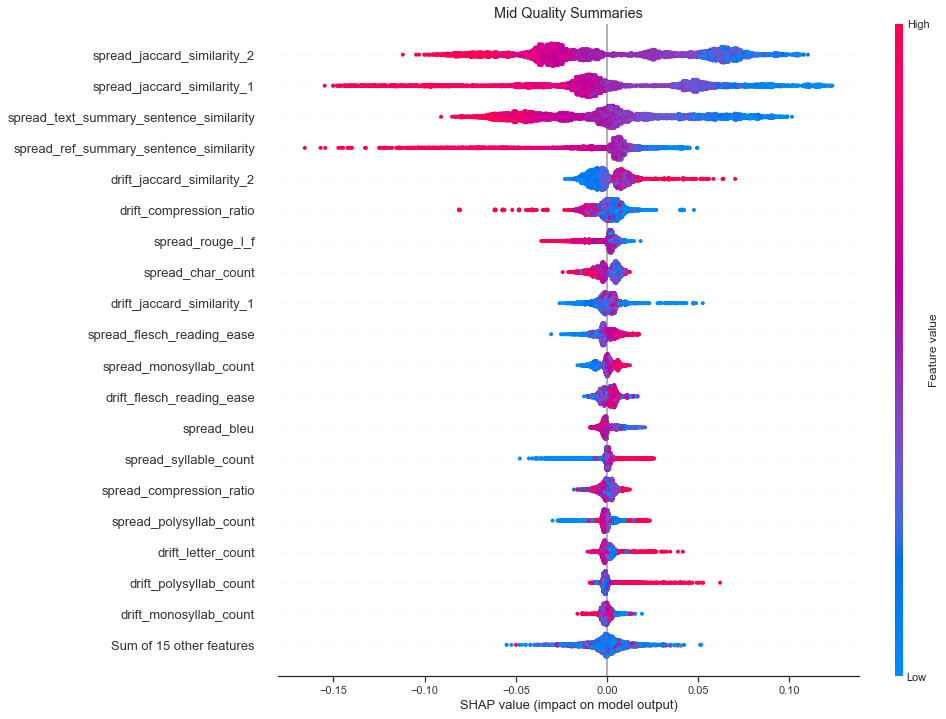

In [53]:
visualize_shap_values(
    [summ_xai_mid.shap_values], 
    [summ_xai_mid.X_test],
    ["Mid Quality Summaries"], 
    filename="figs/shap_values_mid",
)

##### 4.3. High Quality Summaries

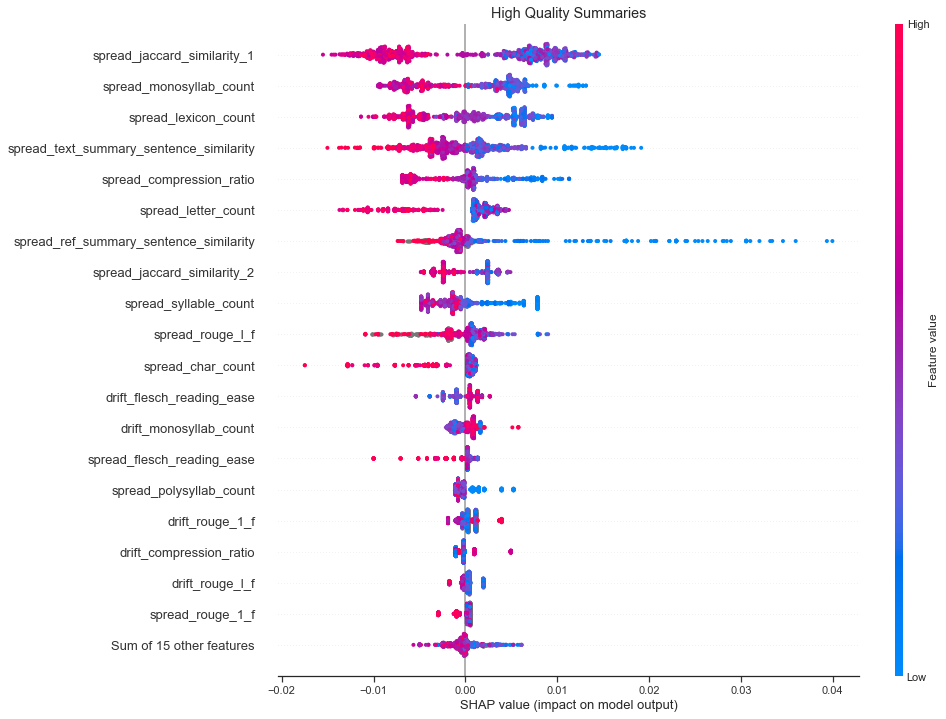

In [54]:
visualize_shap_values(
    [summ_xai_high.shap_values], 
    [summ_xai_high.X_test],
    ["High Quality Summaries"], 
    filename="figs/shap_values_high",
)

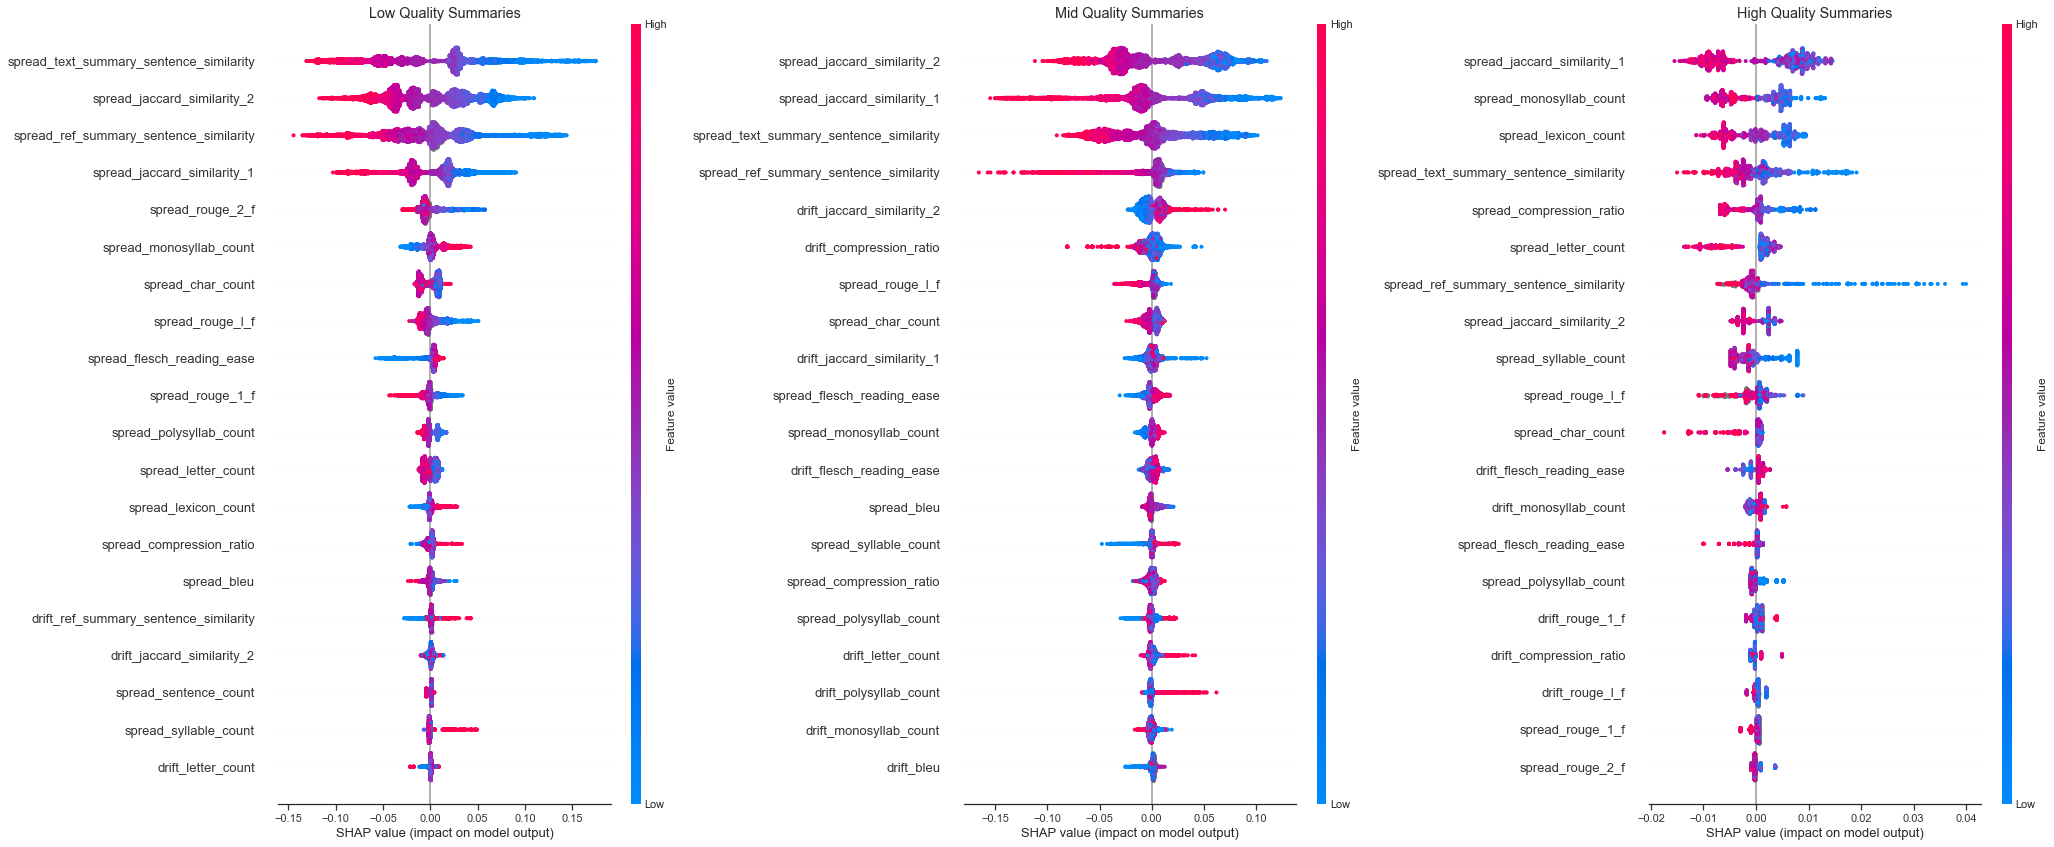

In [55]:
visualize_shap_values(
    shap_values_list=[summ_xai_low.shap_values, summ_xai_mid.shap_values, summ_xai_high.shap_values],
    X_test_list=[summ_xai_low.X_test, summ_xai_mid.X_test, summ_xai_high.X_test],
    titles=["Low Quality Summaries", "Mid Quality Summaries", "High Quality Summaries"],
    filename="figs/shap_summary"
)

##### 5. Visualize the mean absolute value of each feature over all the instances (rows) of the dataset. by `fraction preferred to reference` 

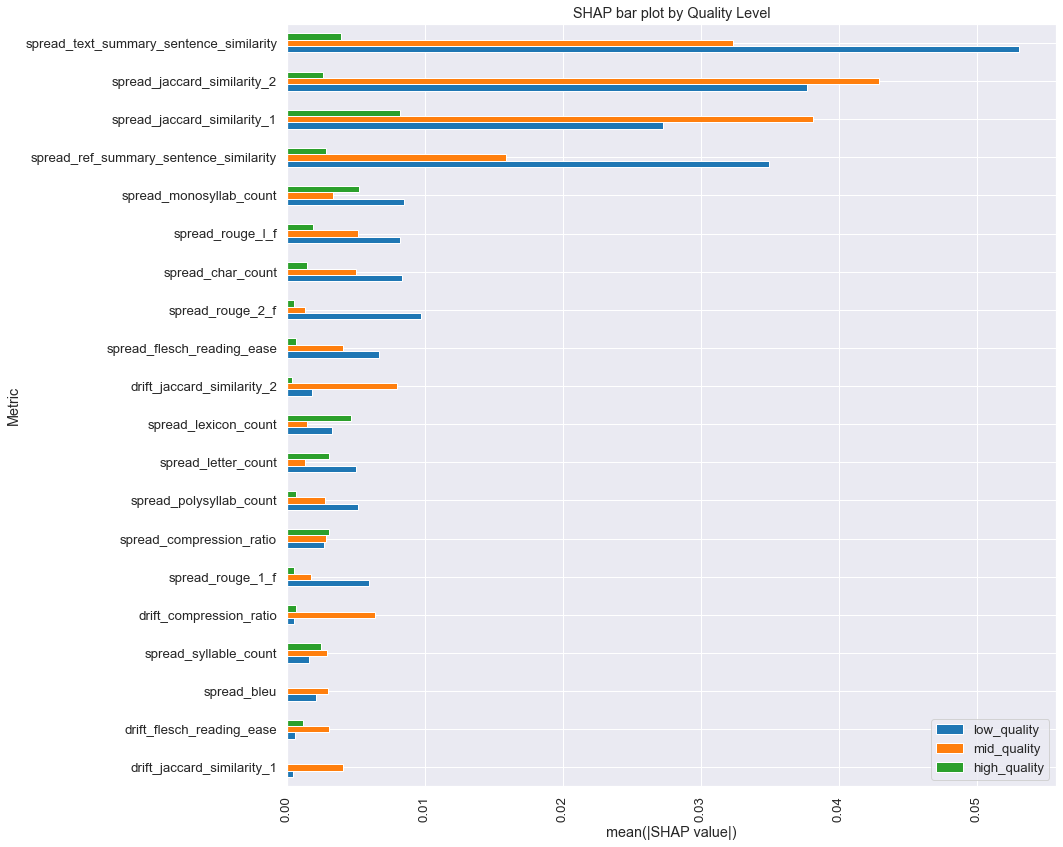

In [63]:
shap_df = visualize_shap_values_by_quality(
    models=[summ_xai_low, summ_xai_mid, summ_xai_high],
    filename="figs/shap_bar_plot_summary",
)

##### 6. Visualize the SHAP dependence plot of each feature of the dataset. by `fraction preferred to reference` 

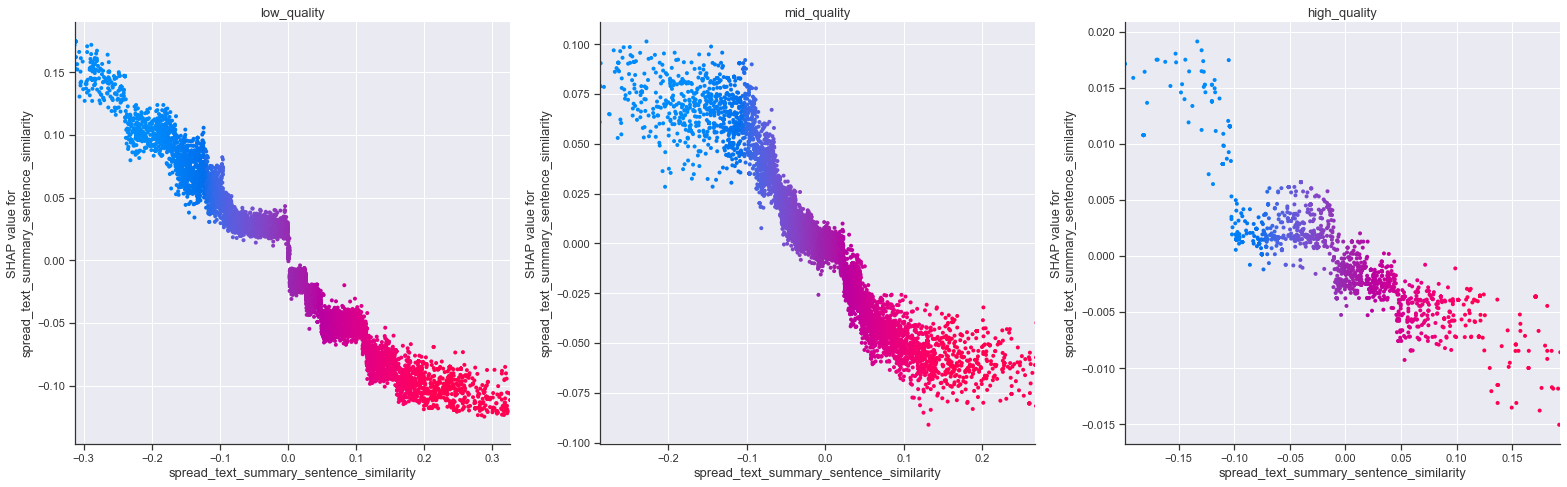

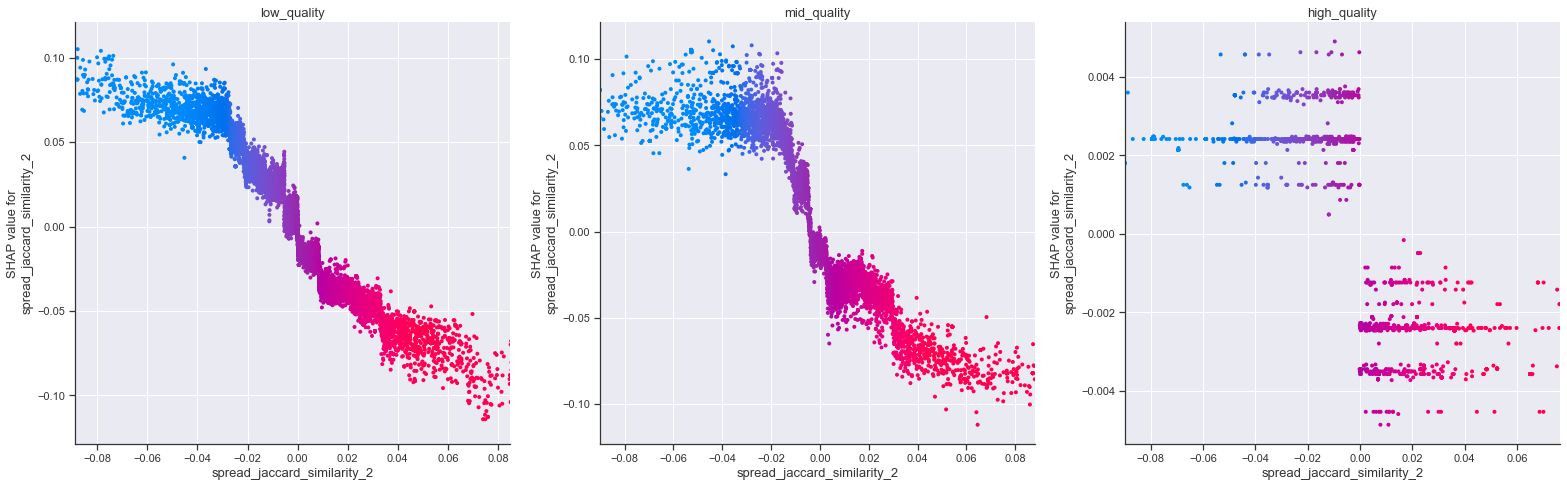

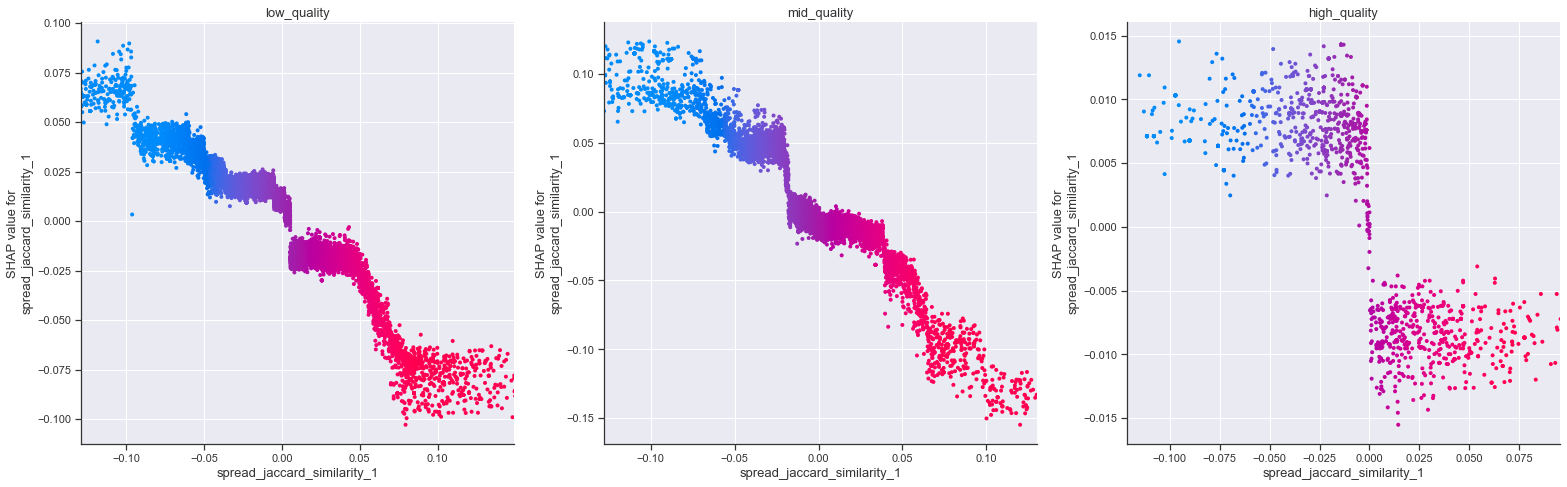

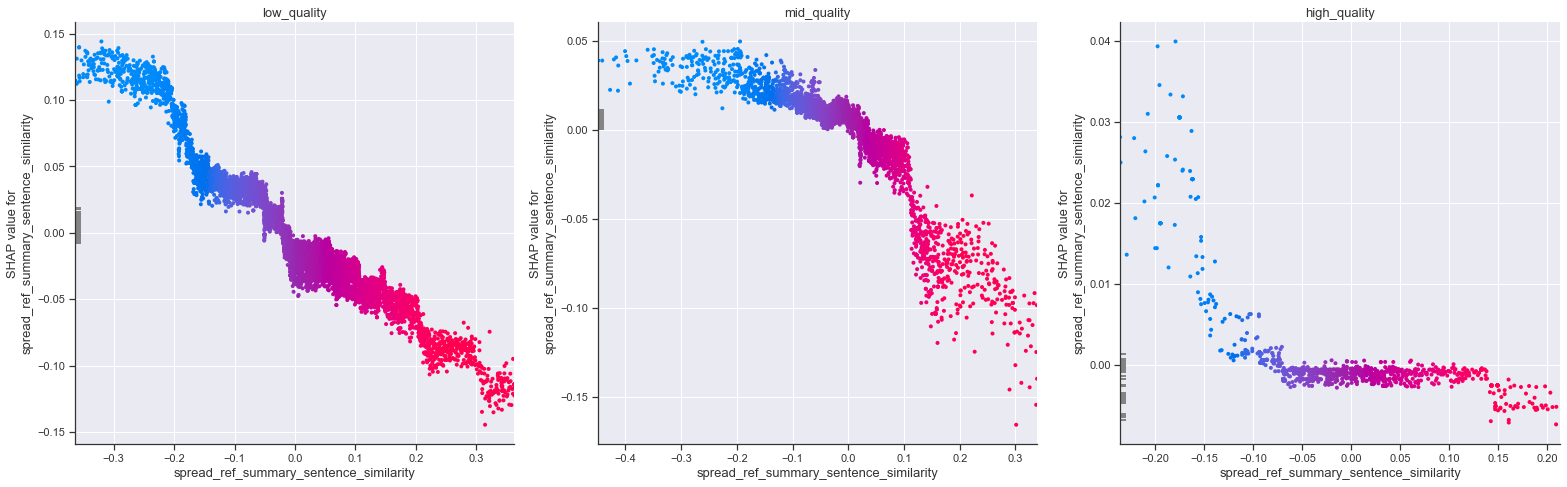

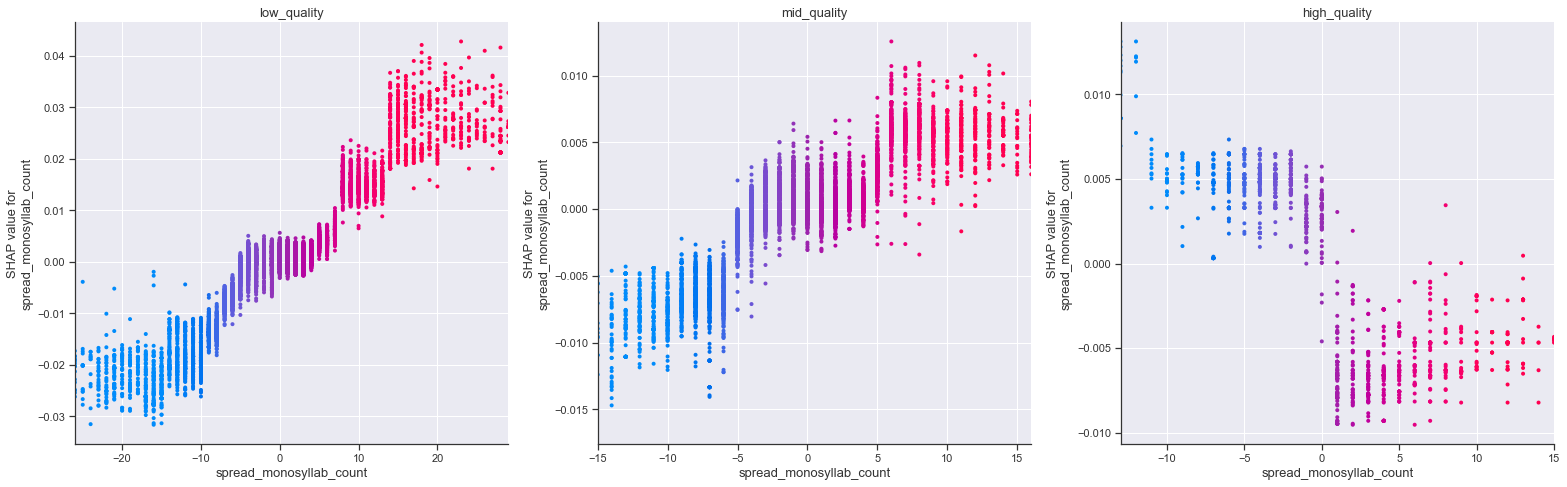

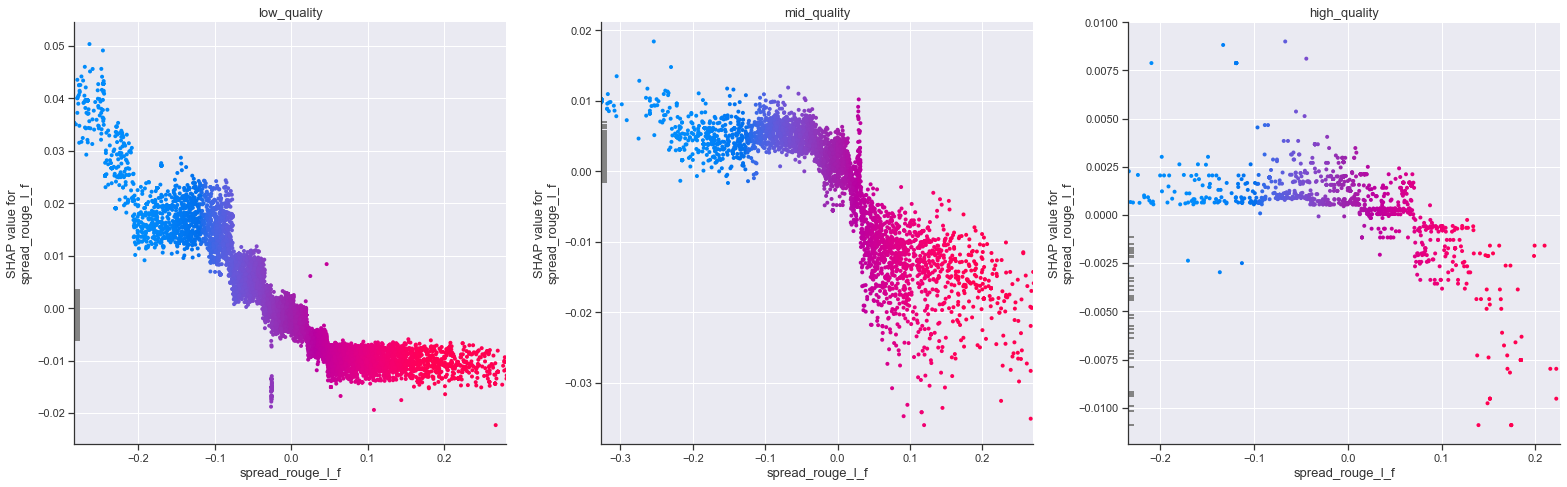

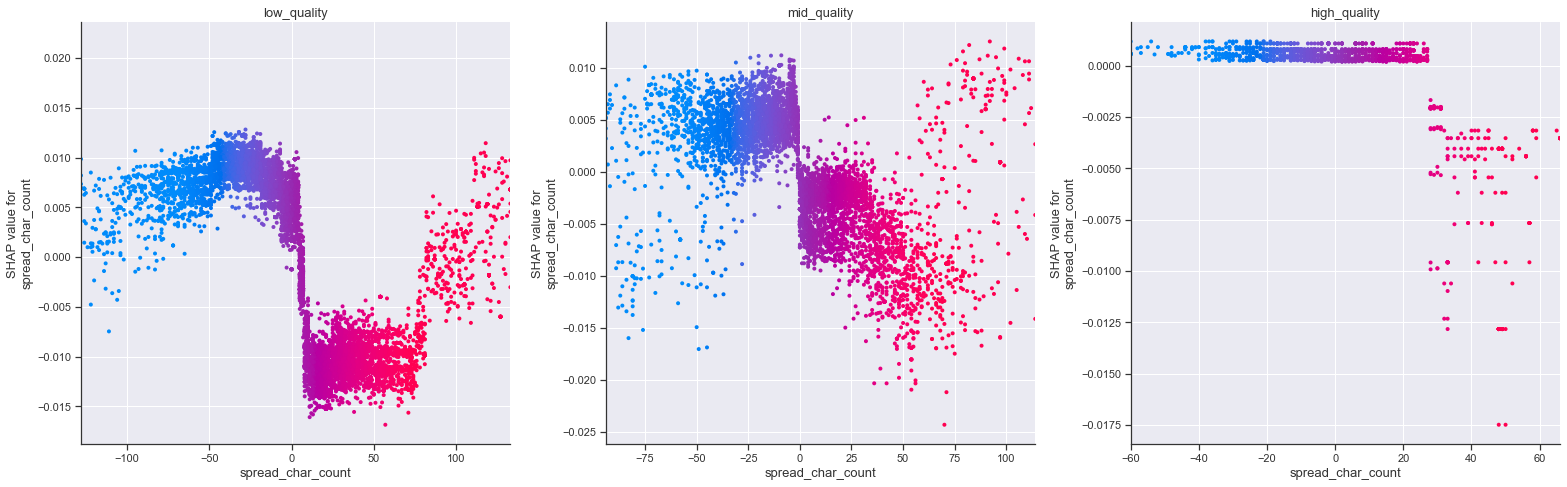

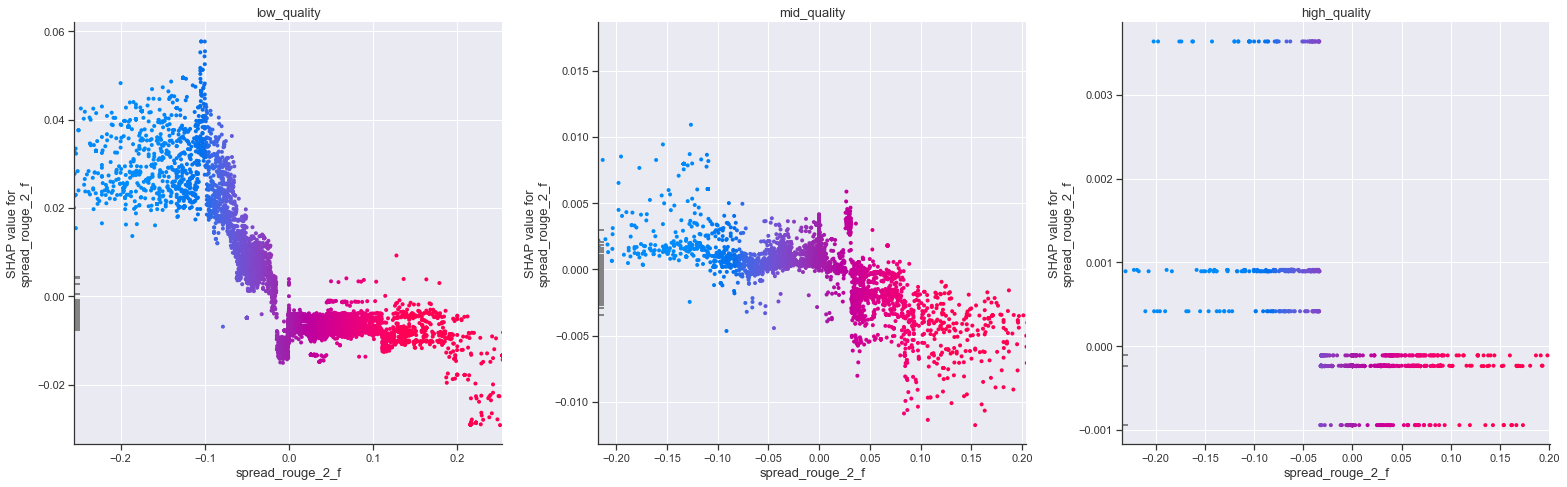

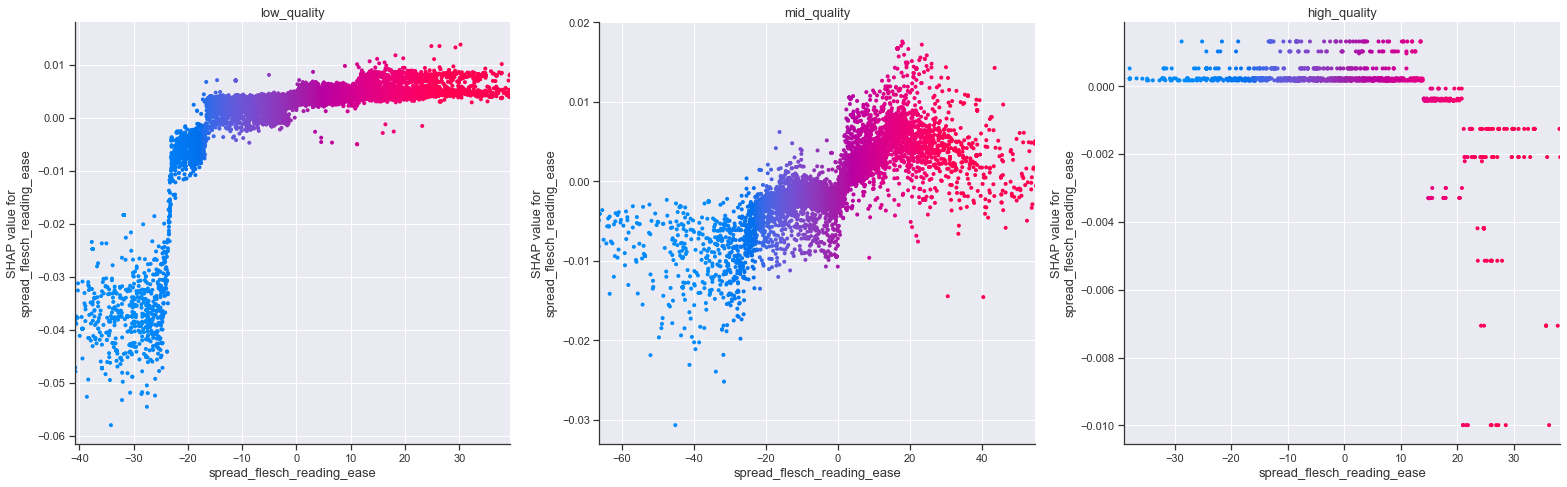

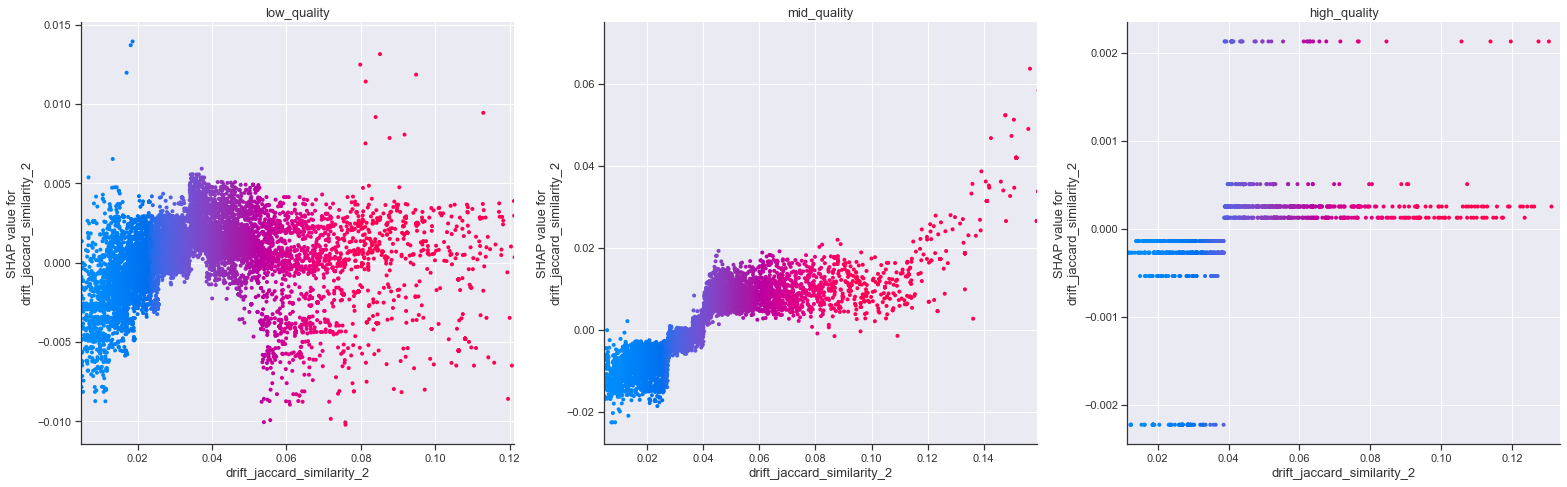

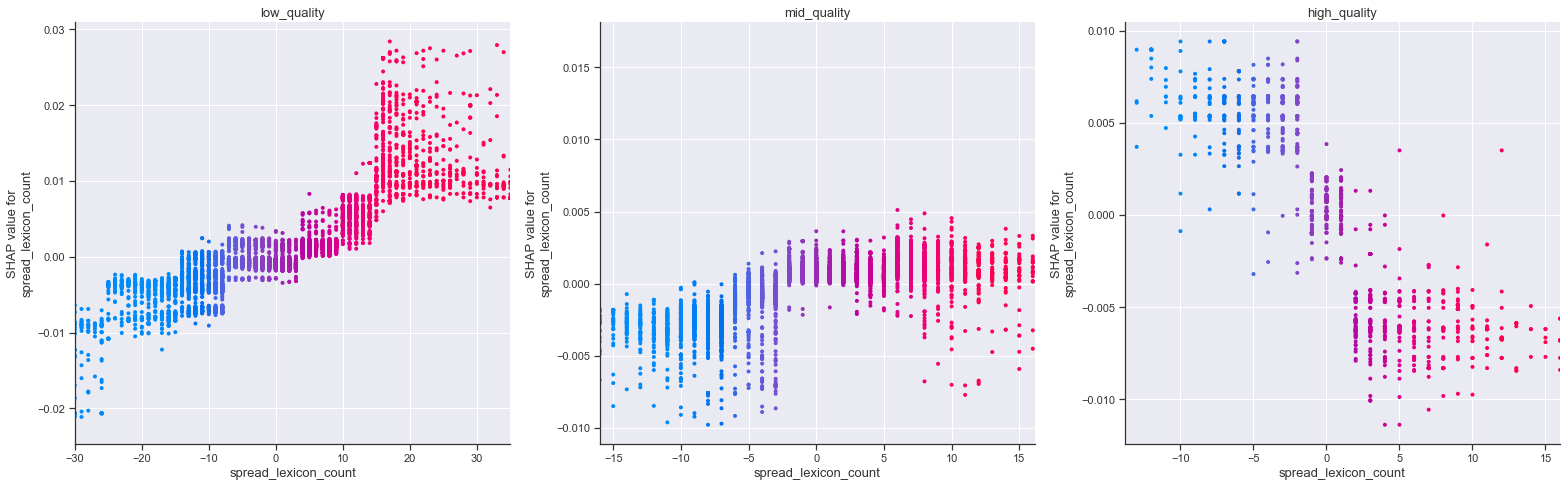

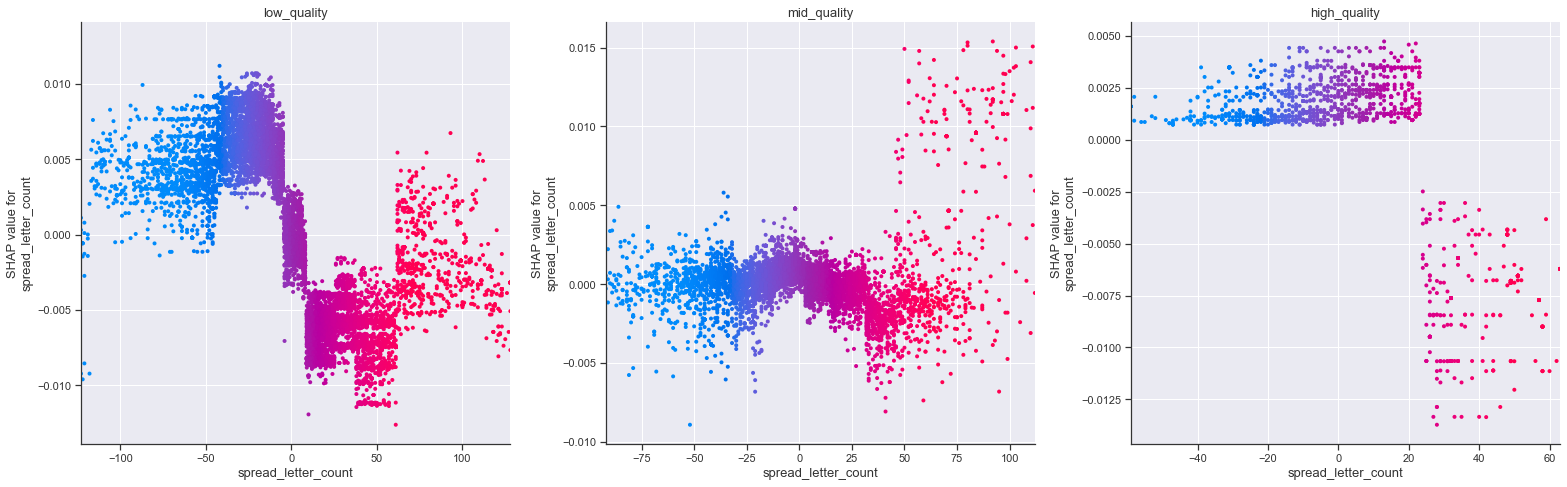

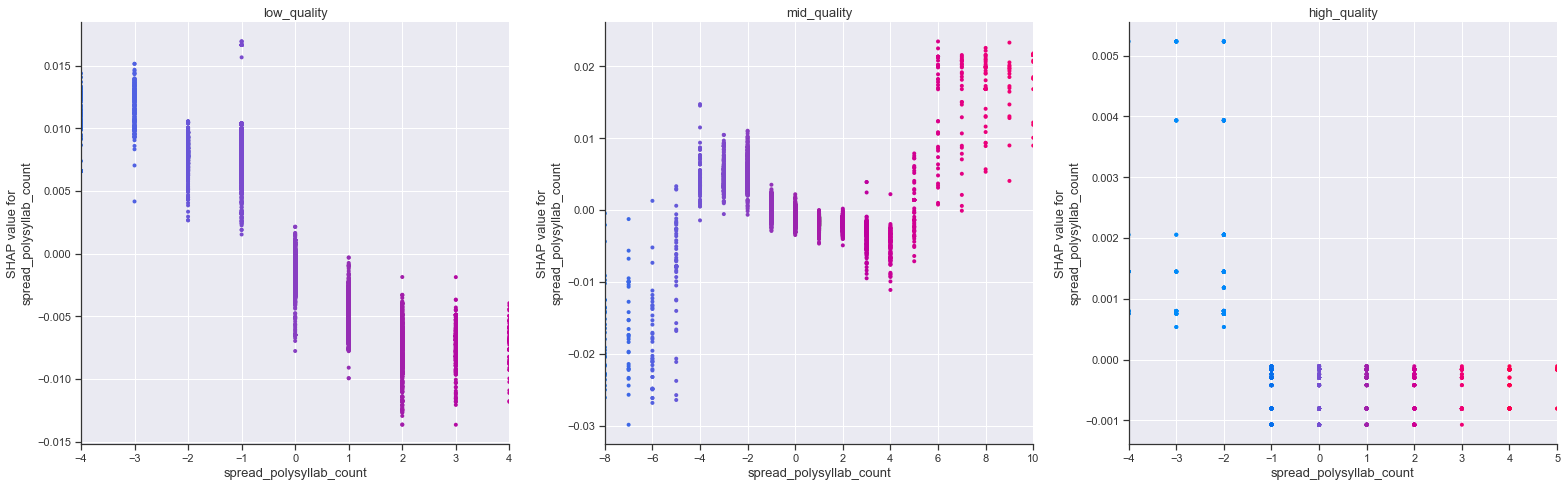

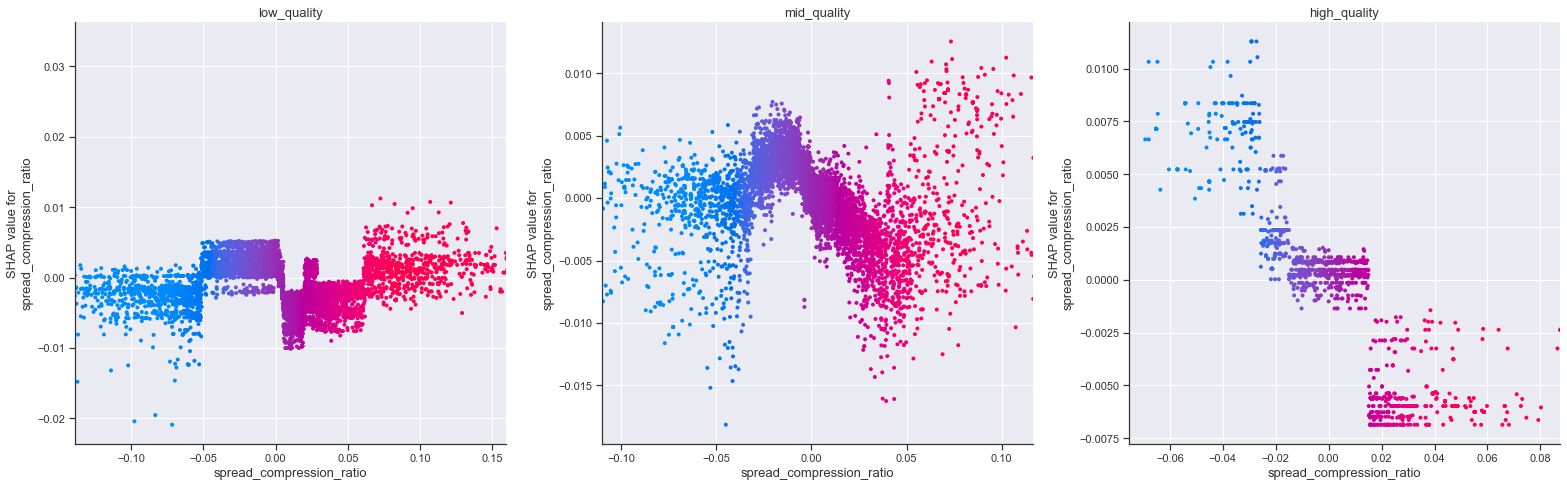

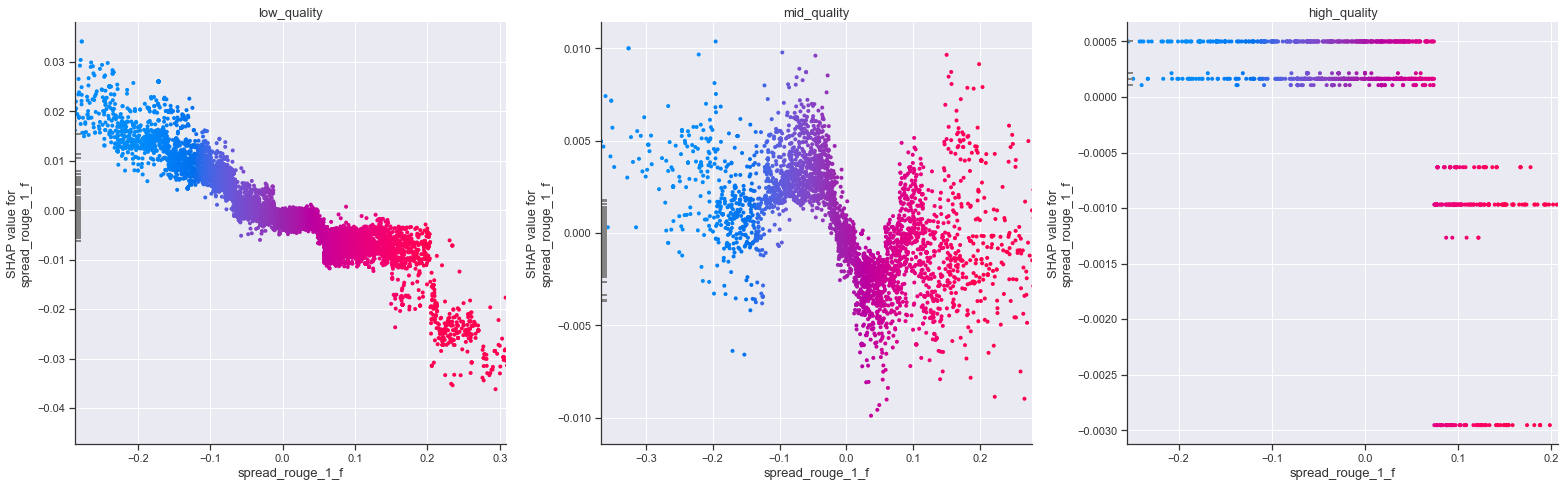

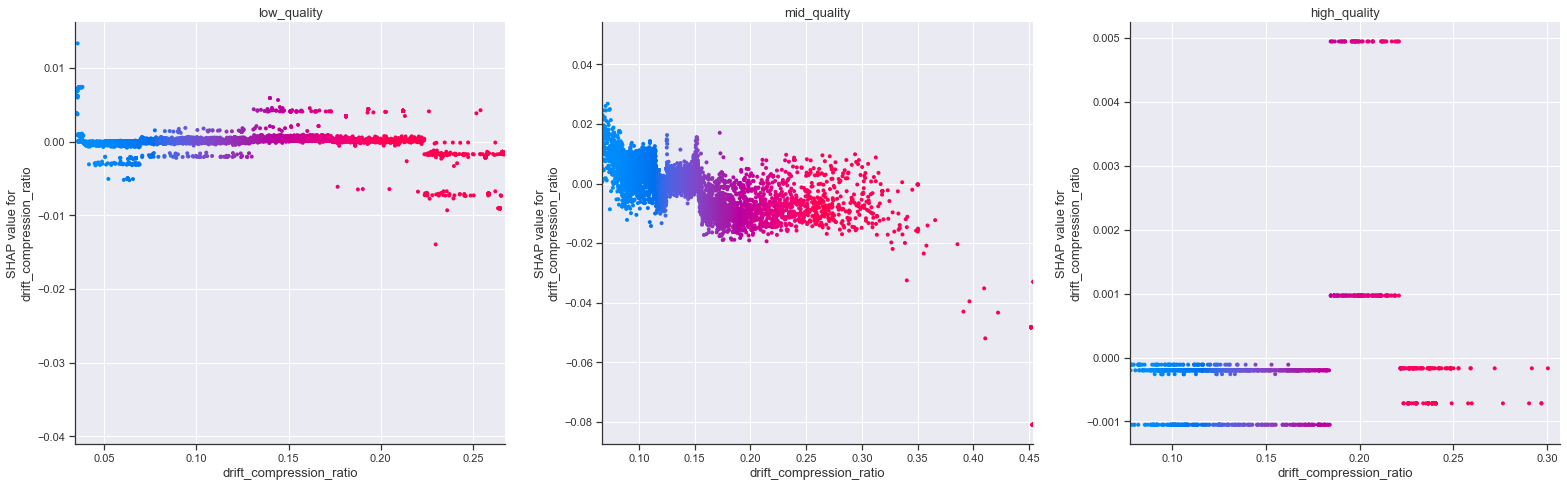

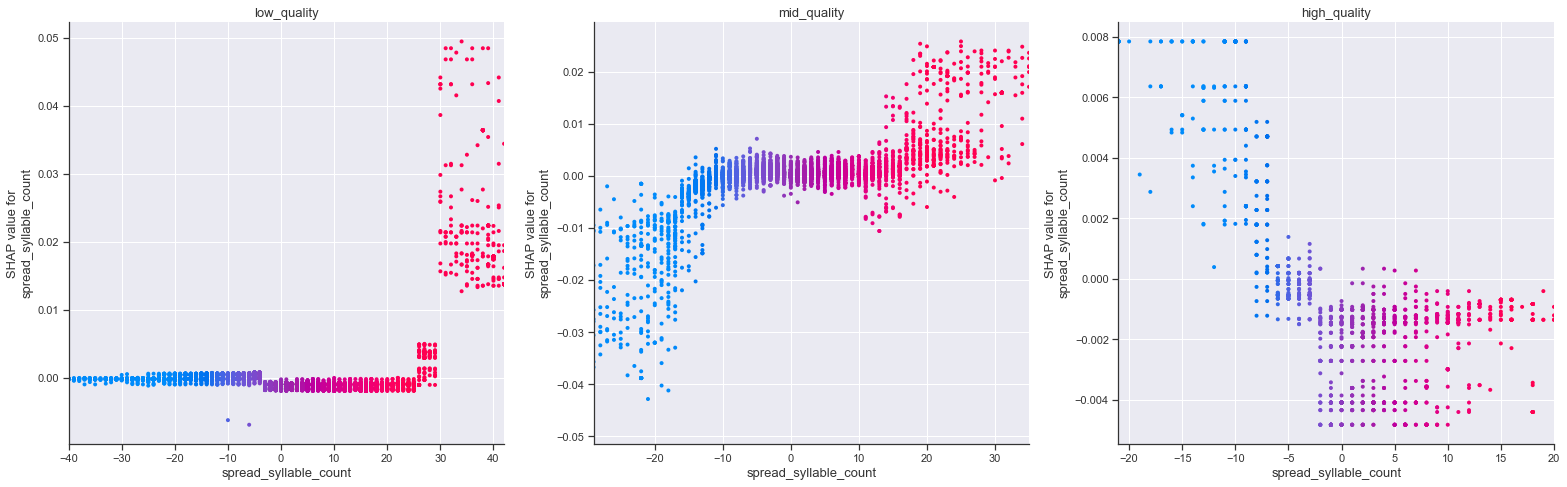

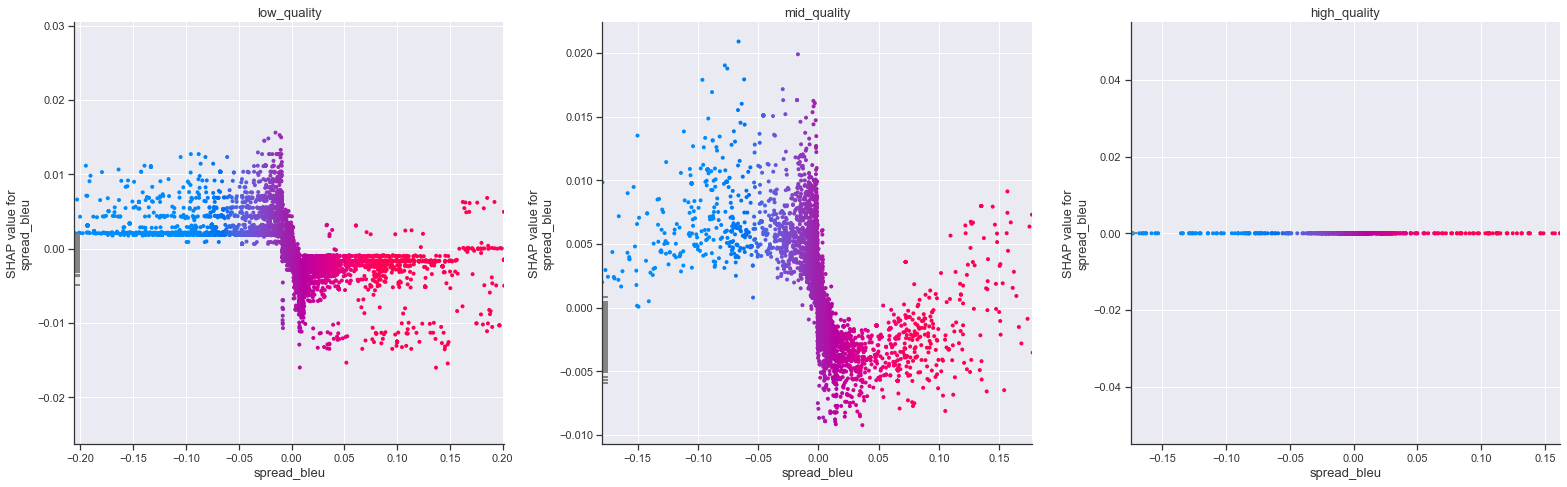

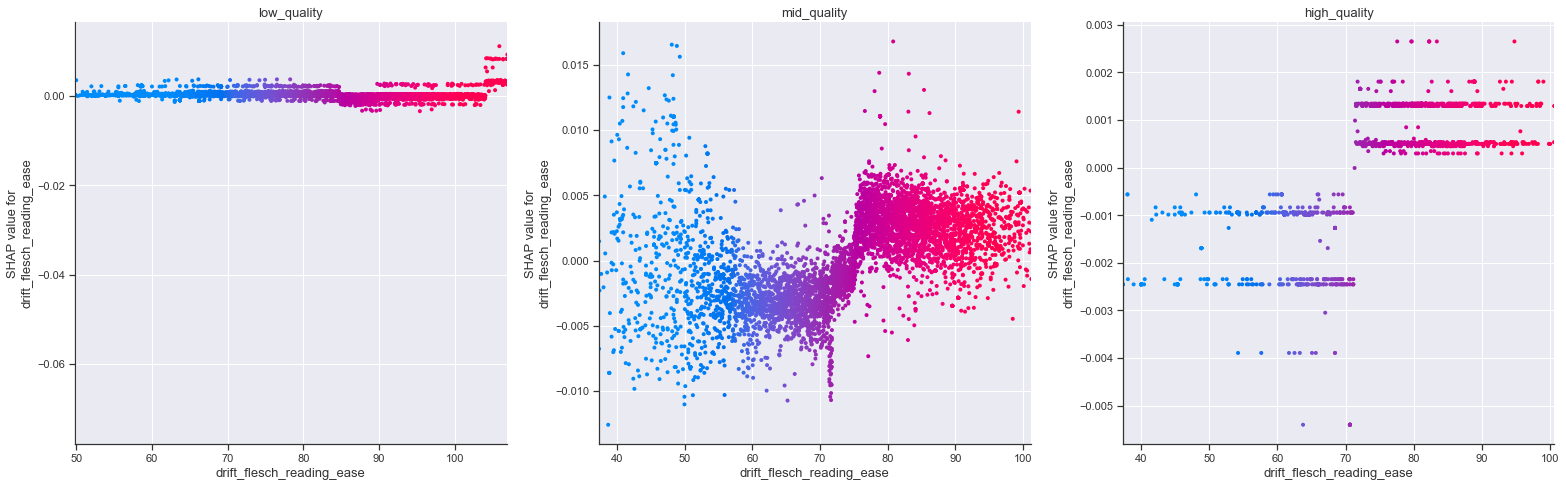

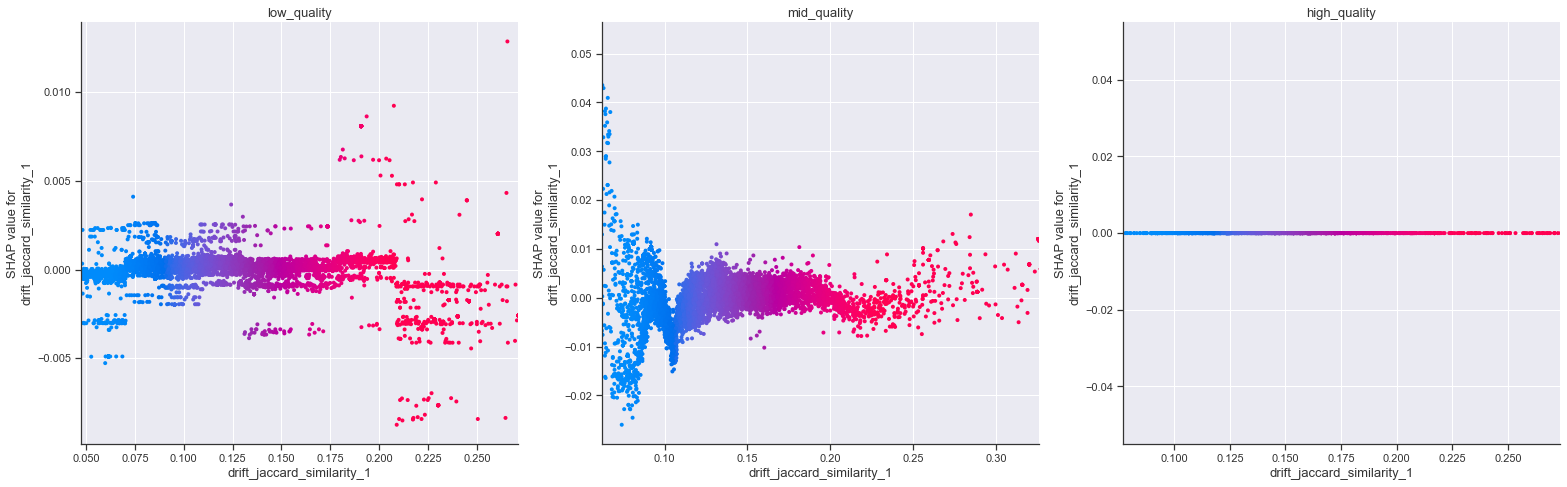

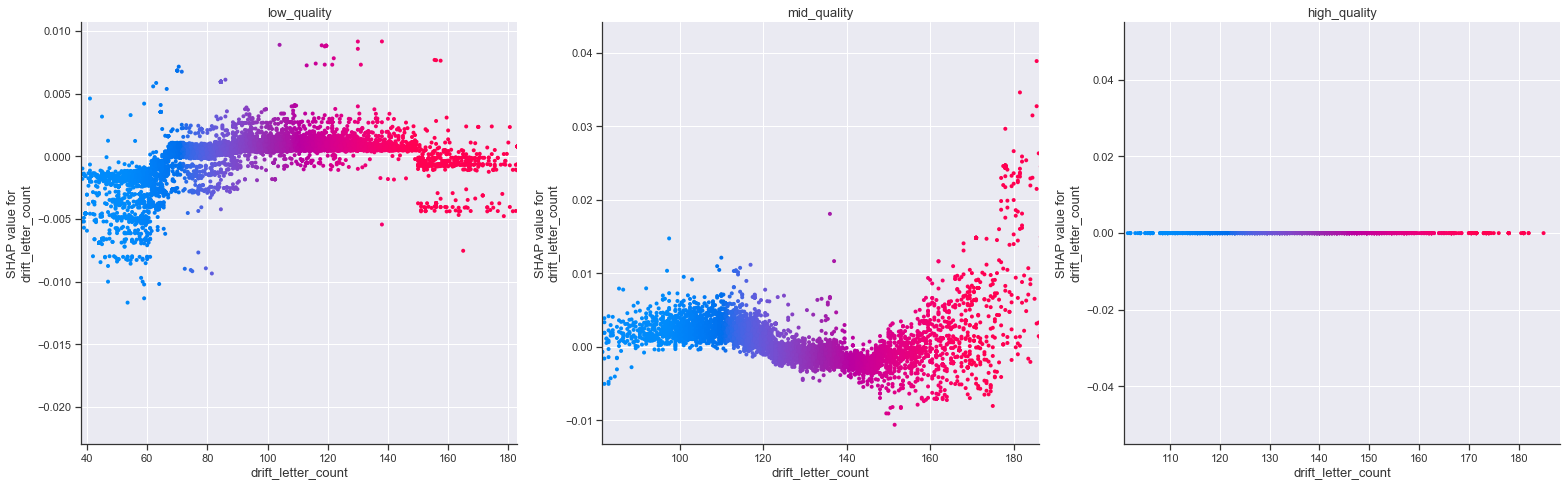

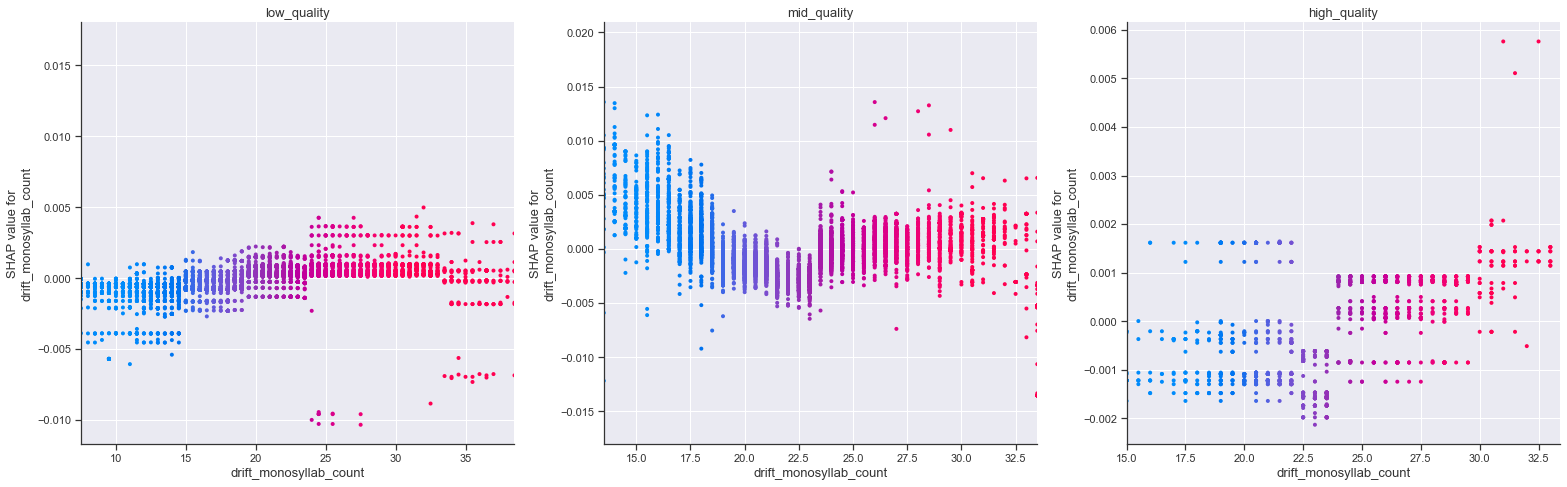

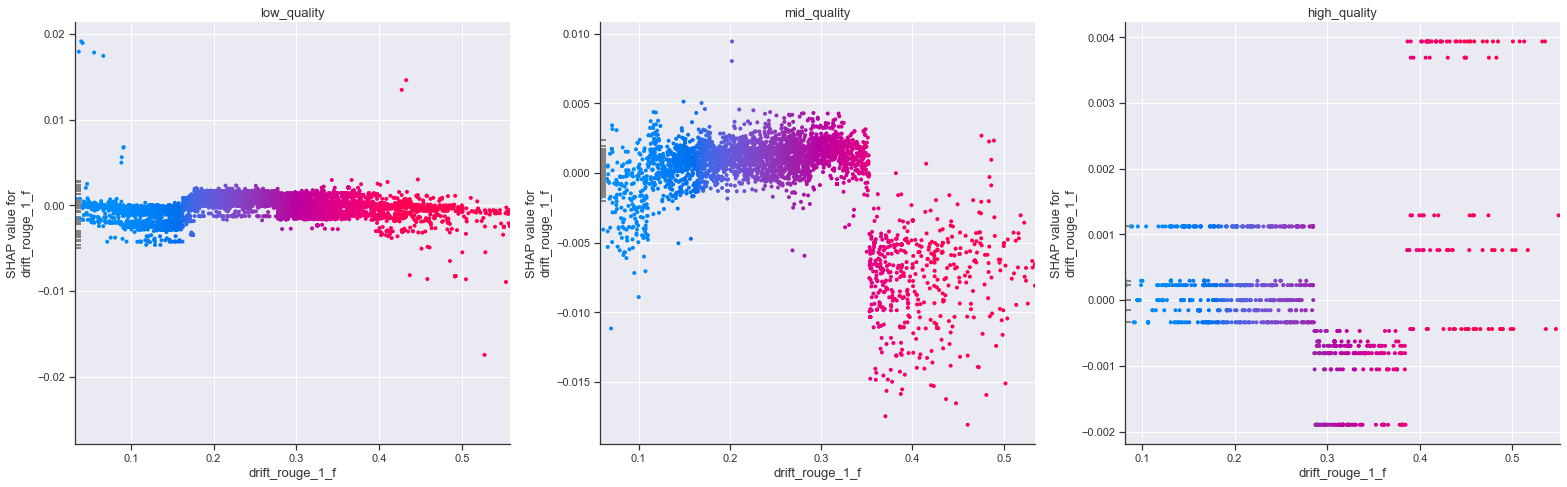

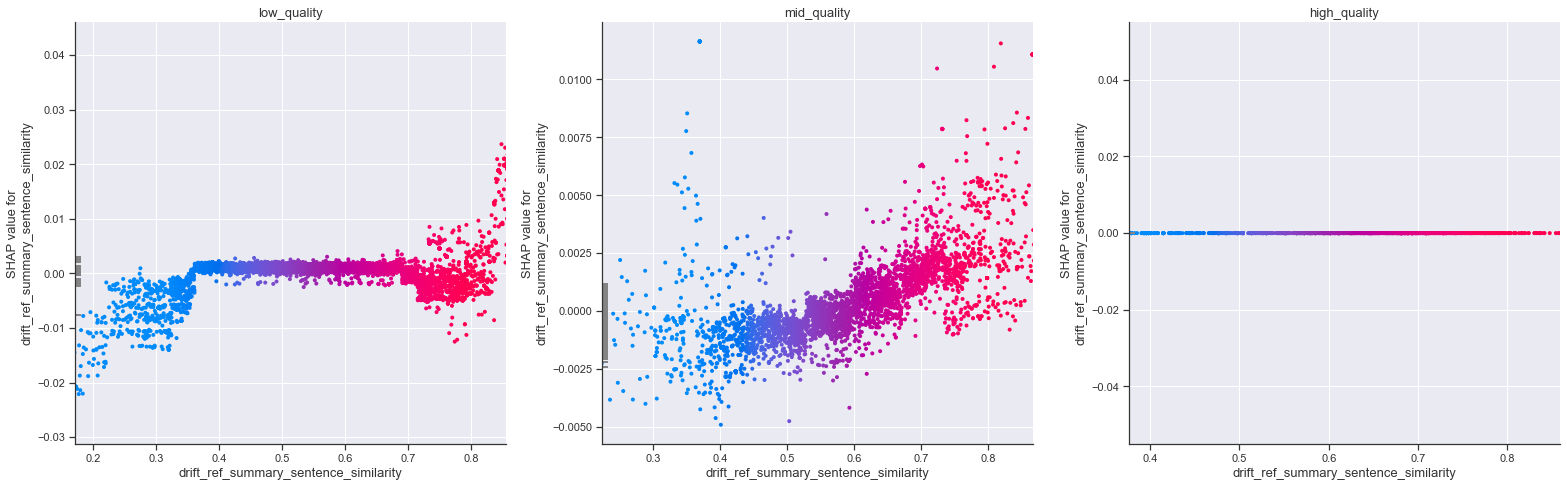

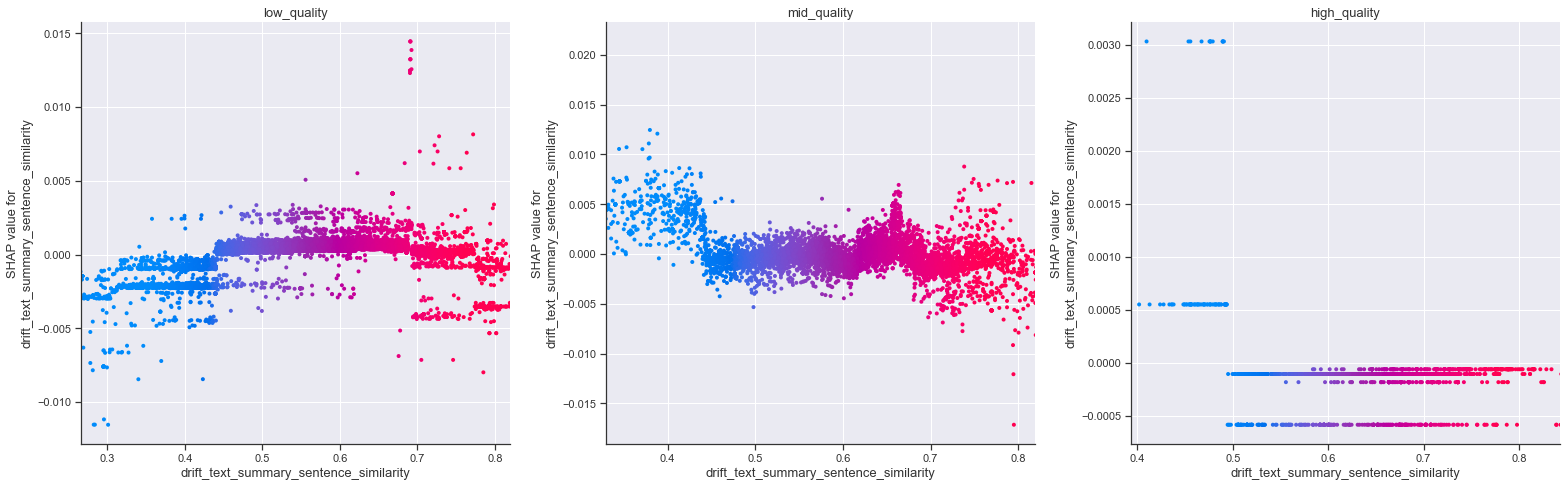

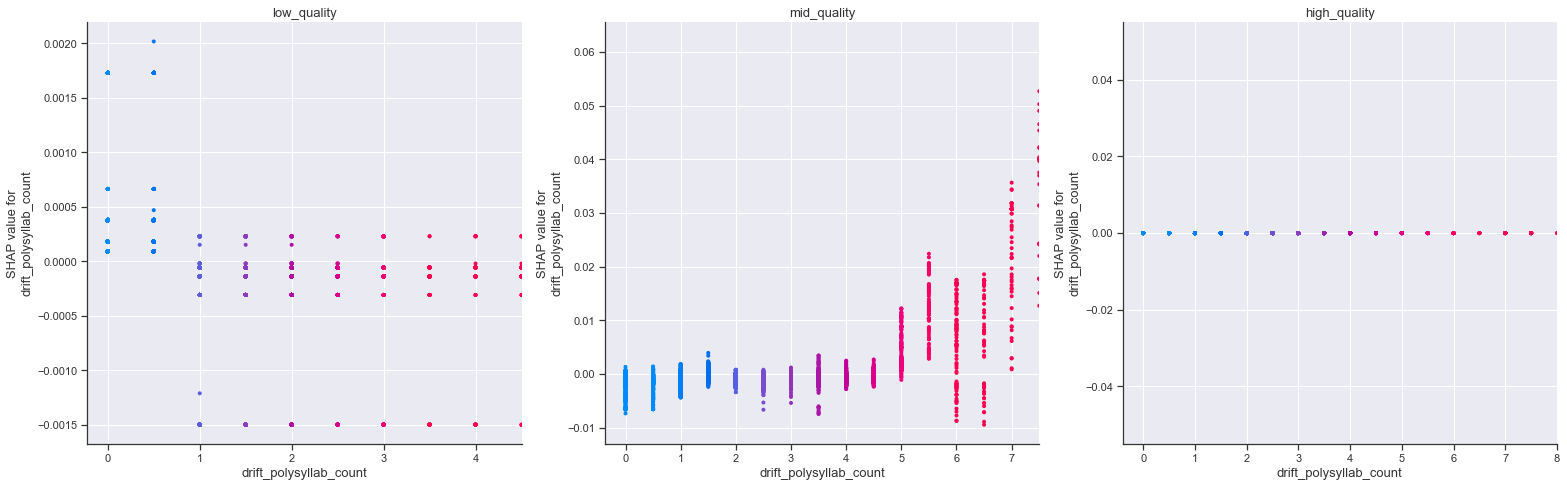

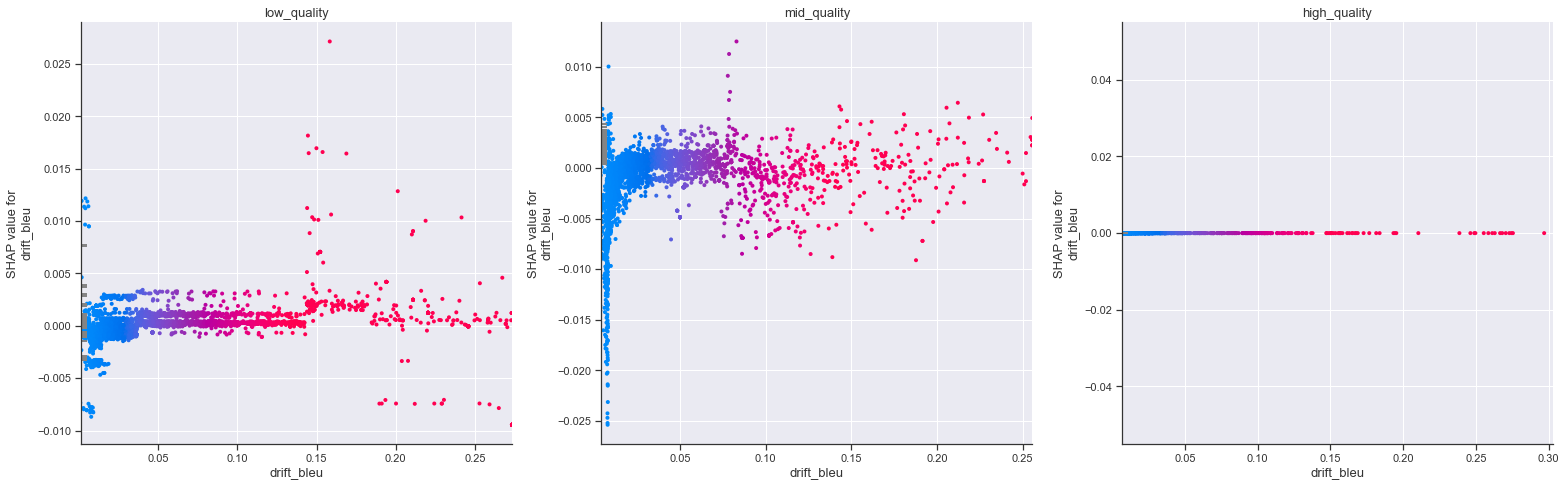

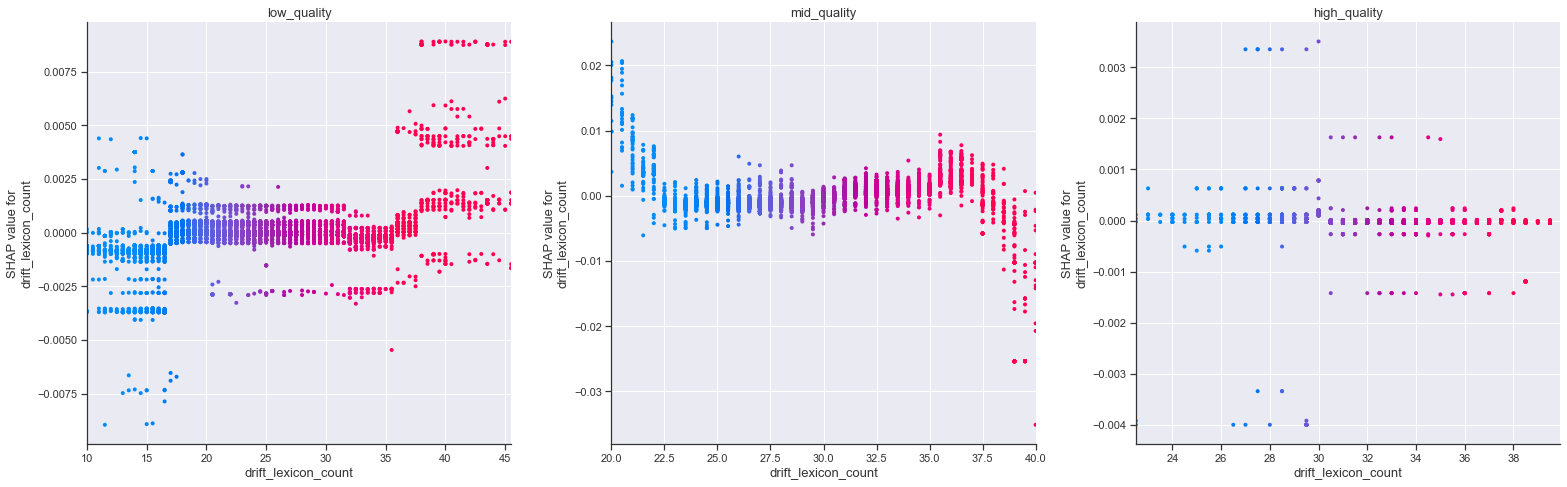

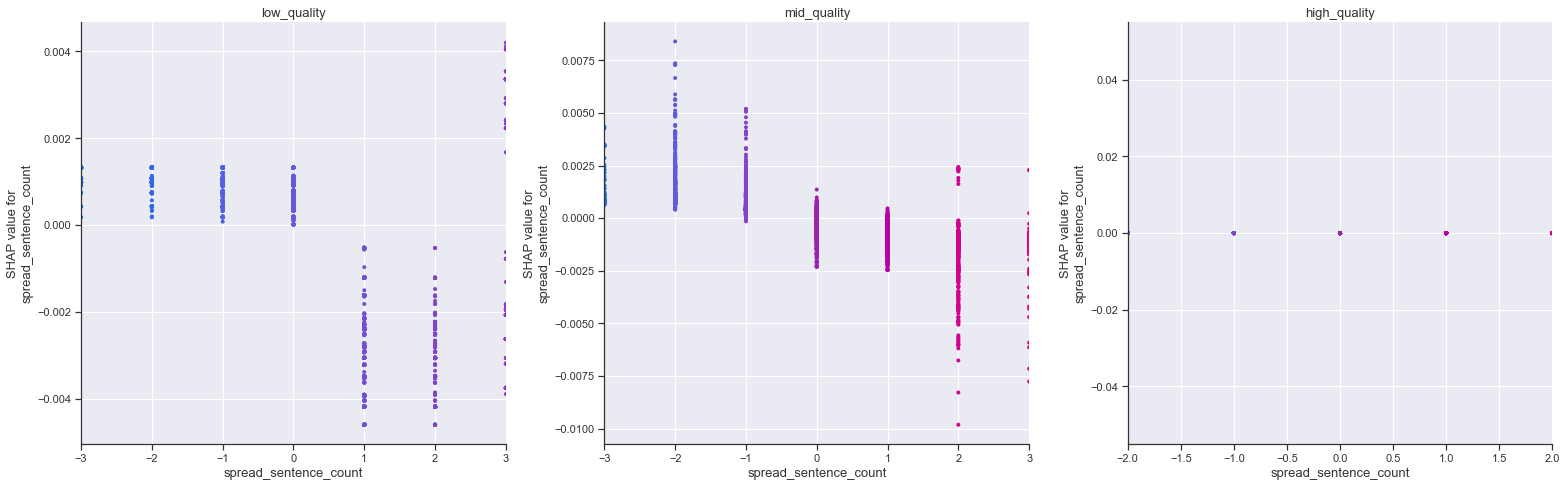

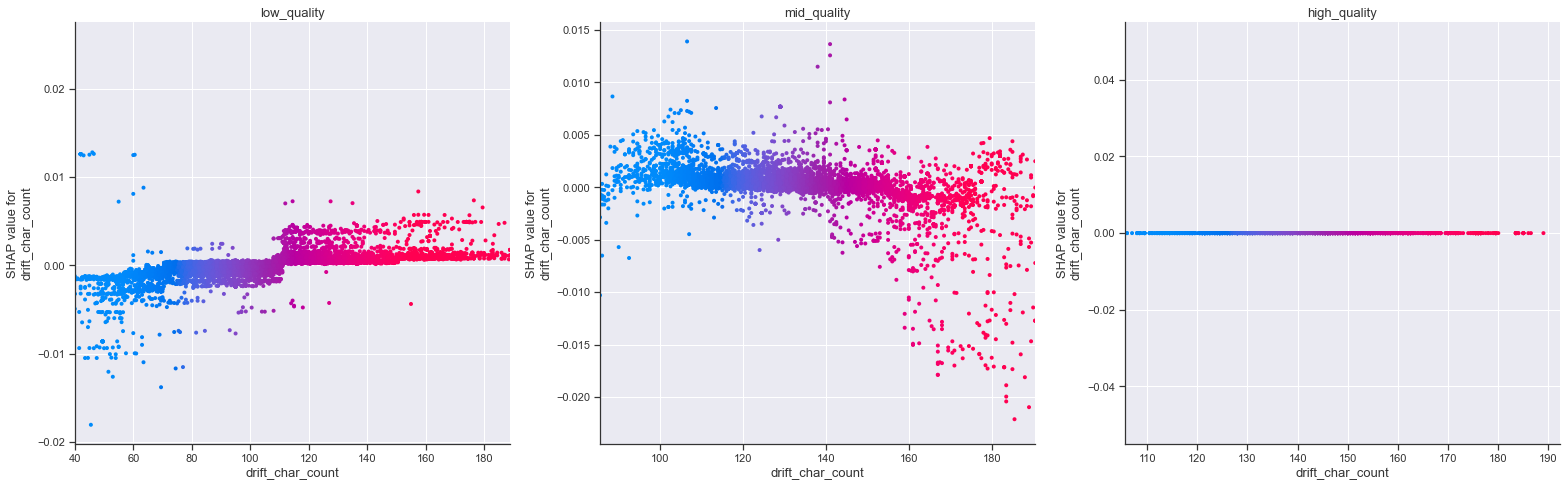

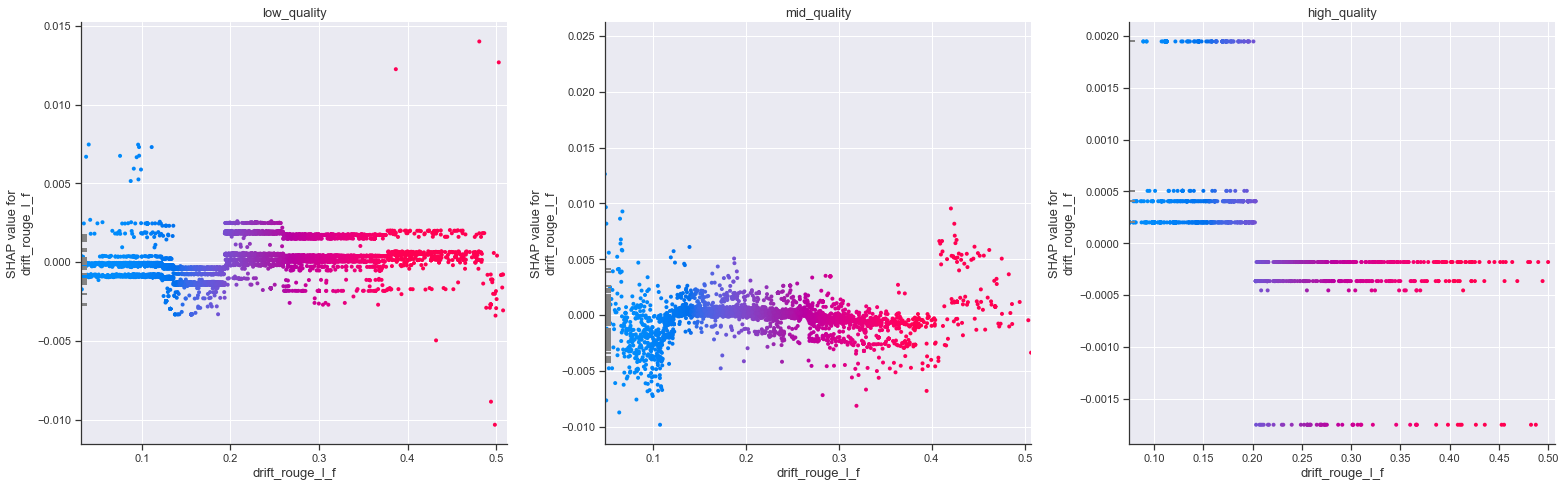

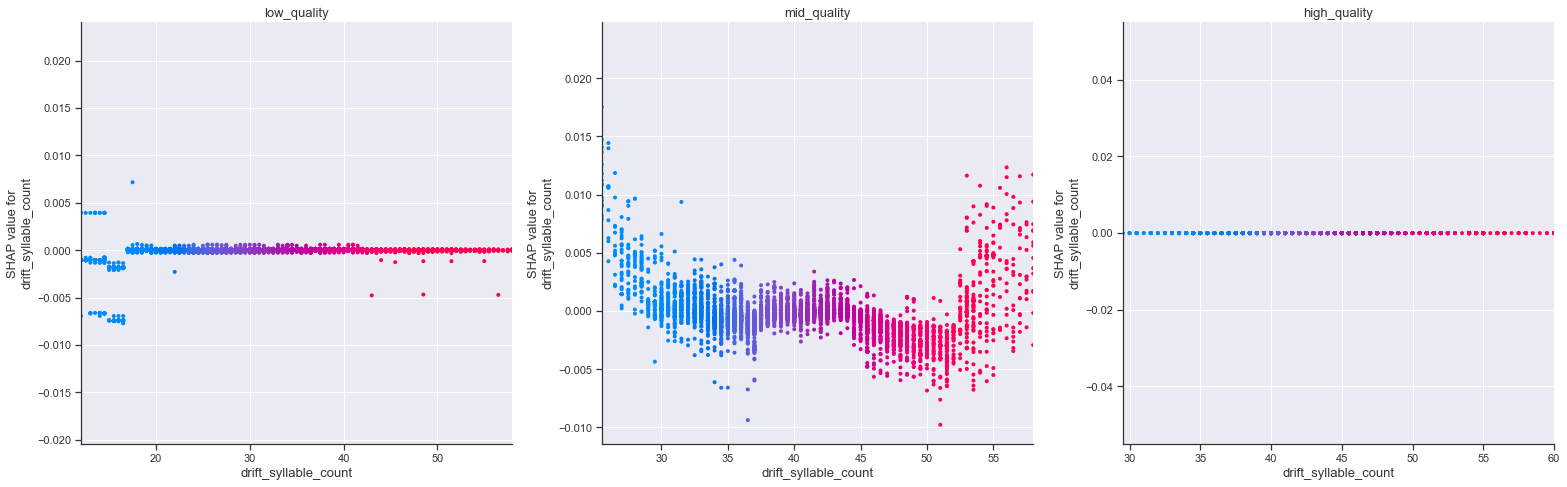

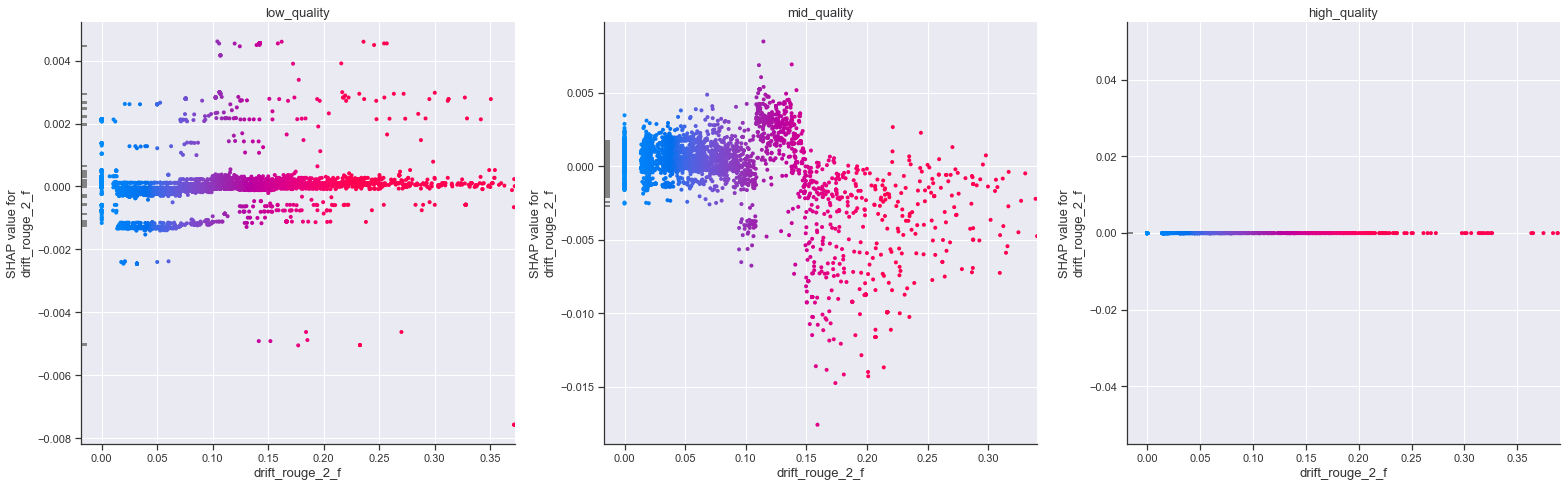

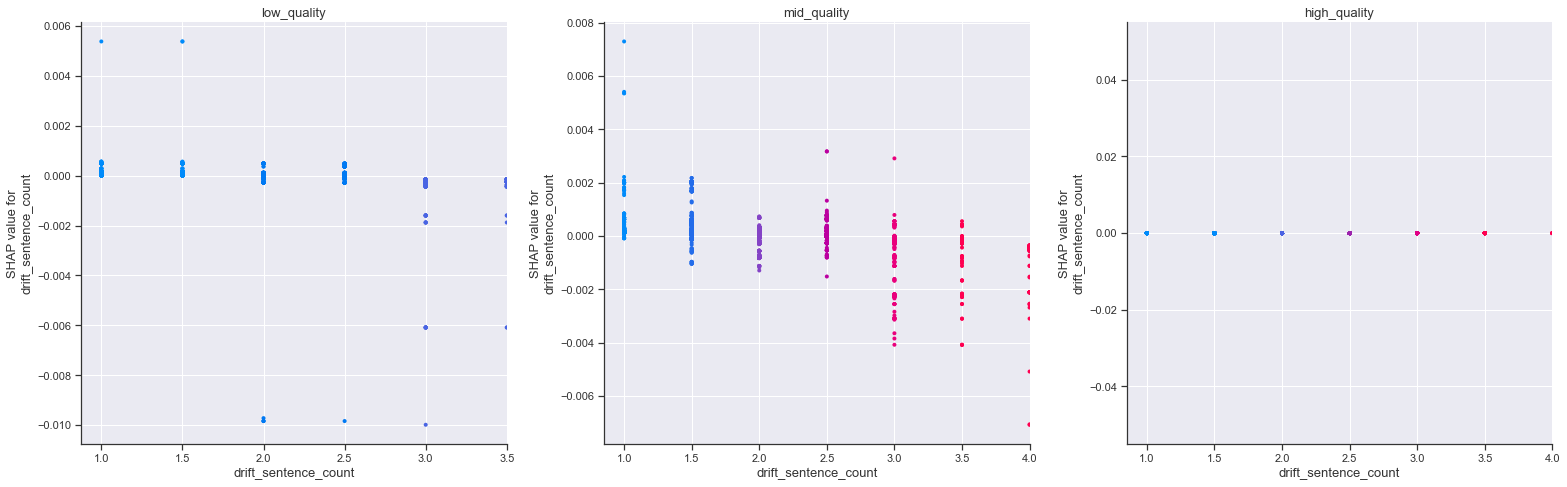

In [85]:
# SHAP dependence plot
for i, topk in enumerate(shap_df.iloc[::-1].index[:]):
    plot_shap_dependence(
        metric=topk, 
        models=[summ_xai_low, summ_xai_mid, summ_xai_high], 
        filename=f"figs/shap_dependence/{i}_{topk}_shap_dependence_plot")